<a href="https://colab.research.google.com/github/ele9996/Heart-failure-clinical-records-analysis/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Heart failure data analysis

The goal of the project is to try to predict if a patient with heart failure is likely to survive or not and if there are some driving factors that may lead to heart failure.


##Import useful libraries


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

#valutare inserzione seed np.random.seed(123)

##Dataset visualization and data exploration


In the following code snippet a visualization of the data is provided

In [47]:
#Dataset import and graphical visualization
df = pd.read_csv('https://raw.githubusercontent.com/ele9996/Heart-failure-clinical-records-analysis/master/heart_failure_clinical_records_dataset.csv')
df


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


I check the correlation between attributes in order to try to eliminate one of the two having high correlation between each other

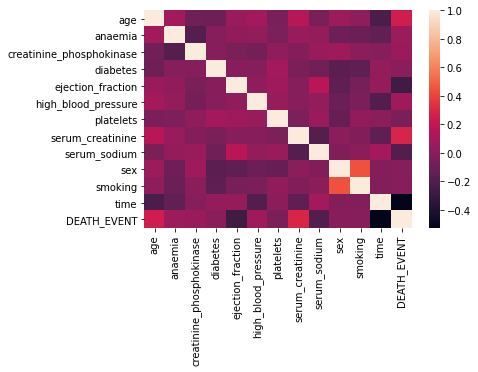

In [48]:
#I calculate correlation and print the correlation matrix
corr = df.corr()
sns.heatmap(corr)
#I notice that that there are no attibutes that are highly correlated one with another so selecting features by imposing a threshold on the correlation seems not to be a good idea
#valuta box plot and the distribution plot for the feature (both before and after the pca)

Since the dimensionality of the data is quite